## **Question 1**

In [1]:
import numpy as np
from scipy.signal import fftconvolve, hilbert
from obspy import read, Stream, Trace
import matplotlib.pyplot as plt
from matplotlib import gridspec
from obspy.core import AttribDict

# def function
def smooth_avg(arr, winlen):
    """
    Smoothing a time series by averaging its values in a moving window. This averaging 
    window operation can be done efficiently with an convolution in the frequency domain.
    """

    window = np.ones(winlen) / (1.0 * winlen)
    return fftconvolve(arr, window, 'same')

def spectral_whitening(arr, delta, freq_width, returnweight=False):
    """
    Frequency whitening of a time series by balancing its spectrum by smoothed absolute
    array of the spectrum.
    
    arr        : input seismogram
    delta      : sampling time step of the input
    freq_width : spectral whitening width
    returnweith: return the averaging width or not
    """
    npts = len(arr)
    carr = np.fft.fftshift(np.fft.fft(arr, 2*npts-1))

    Nyfreq = 0.5 / delta
    spec_step = Nyfreq / npts
    if freq_width != None:
        winlen = int(0.5 * freq_width / spec_step) * 2 + 1
        weight = smooth_avg(np.abs(carr), winlen)
        if any(weight < 1e-8): raise Exception('Zero division')
        
        carr /= weight
        carr[weight<1e-8] = 0

    if returnweight:
        return carr[npts-1:2*npts], weight[npts-1:2*npts]
    else:
        return carr[npts-1:2*npts]
    
def compute_whiten_auto(tr,freq_width,lc,hc, autolim):
    delta=tr.stats.delta
    npts=tr.stats.npts
    whiten_spectrum=spectral_whitening(tr.data,tr.stats.delta,freq_width)
    w_auto = np.fft.irfft(np.abs(whiten_spectrum)**2)
    w_auto_tr=Trace(header={'npts':len(w_auto),'delta':delta},data=w_auto)
    # post processing: tapering and filtering
    taper_width = 10/(w_auto_tr.stats.npts * w_auto_tr.stats.delta)
    w_auto_tr.taper(type='cosine', max_percentage=taper_width)
    w_auto_tr.filter('bandpass', freqmin=lc, freqmax=hc, corners=4, zerophase=True)
    w_auto_tr.trim(w_auto_tr.stats.starttime + autolim[0], w_auto_tr.stats.starttime + autolim[1])
    w_auto_tr.taper(type='cosine', max_percentage=taper_width)
    return w_auto_tr

def data_stack(stream, order):
    stack = 0
    phase = 0j
    if order == 0:
        for acorr in stream:
            stack += acorr.data
        stack /= len(stream)
        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack)
    else:
        for acorr in stream:
            stack += acorr.data

            ## calculate phase
            asig = hilbert(acorr.data)
            phase += asig / np.abs(asig)
        stack /= len(stream)
        weight = np.abs(phase / len(stream))
        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack * weight**order)



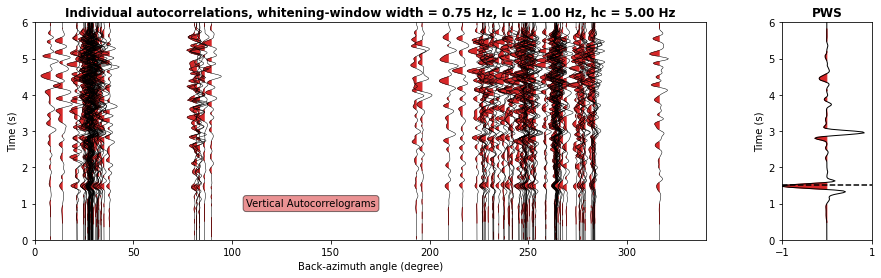

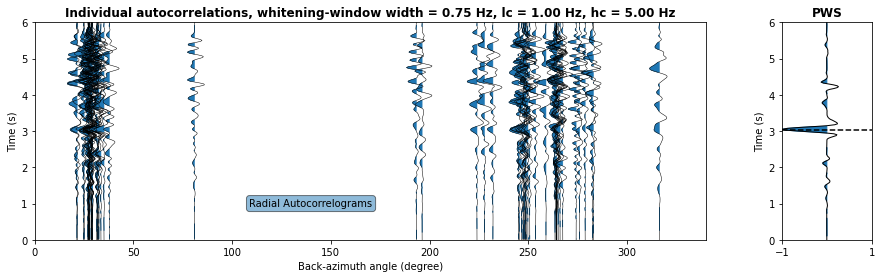

In [2]:
freq_width = 0.75
lc = 1.0
hc = 5.0
# read data
stz = read("ST01/*Z.SAC")
stn = read("ST01/*N.SAC")
# save back-azimuth to radial components
for i in range(len(stz)):
    for j in range(len(stn)):
        if stz.traces[i].stats.sac.gcarc == stn.traces[j].stats.sac.gcarc:
            stn.traces[j].stats.sac.baz = stz.traces[i].stats.sac.baz

# The folder ST01 has seismogram that has data 25 seconds before and 180 seconds after P arrival.
# You need tocut this data 10 seconds before and 30 s after P arrival.
# Use whitening window width of 0.75 Hz and phase weighted stack of order 2.
# Use the bandpass filter of 1-5 Hz. Therefore, we need 15 seconds after starttime and
# the duration of signal is 40 seconds.

def process(stream, color, hline, autolim):
    """
    stream: Stream
    color: color for filling
    hline: plotting the line for discontinuity
    autolim: limit of the y-axis of autocorrelation
    """
    auto_stream = Stream()
    st = stream.copy()
    for i in range(len(st)):
        dt = st.traces[i].stats.starttime
        st.traces[i].trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)
        st.traces[i].detrend("demean");  
        st.traces[i].detrend("simple");  
        whiten_auto=compute_whiten_auto(st.traces[i],freq_width,lc,hc, autolim) # NOTE: change data here
        whiten_auto.normalize()
        sacd=AttribDict()
        sacd.baz=st.traces[i].stats.sac.baz
        # sacd.gcarc=st.traces[i].stats.sac.gcarc
        whiten_auto.stats.sac = sacd
        auto_stream = auto_stream + whiten_auto
    time=np.arange(whiten_auto.stats.npts)*whiten_auto.stats.delta
    # plot
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 2,hspace=0.3,width_ratios=[7.5, 1])
    ax0=plt.subplot(gs[0,0])
    for auto in auto_stream:
        auto.trim(auto.stats.starttime, auto.stats.starttime + 20)
        time=np.arange(auto.stats.npts)*auto.stats.delta
        auto.normalize()
        auto.data = auto.data*5
        epi_dist = auto.stats.sac.baz
        # epi_dist = auto.stats.sac.gcarc
        ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
        ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color=color, where=(auto.data < 0))
    ax0.set_ylim(autolim)
    ax0.set_xlim([0, 340])
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    if st.traces[-1].stats.channel == 'BHZ':
        ax0.text(140,1,"Vertical Autocorrelograms",
                horizontalalignment='center', verticalalignment='center', bbox=props);
    else:
        ax0.text(140,1,"Radial Autocorrelograms",
                horizontalalignment='center', verticalalignment='center', bbox=props);
    ax0.set_xlabel("Back-azimuth angle (degree)")
    ax0.set_ylabel("Time (s)")
    ax0.set_title("Individual autocorrelations, whitening-window width = %.2f Hz, lc = %.2f Hz, hc = %.2f Hz" %(freq_width, lc, hc),
                  weight='bold')
    ax1=plt.subplot(gs[0,1])
    stack=data_stack(auto_stream,2)
    stack.trim(stack.stats.starttime, stack.stats.starttime + 20)
    time=np.arange(stack.stats.npts)*stack.stats.delta

    stack.normalize()
    ax1.plot(stack.data, time, lw=1, color='black')
    ax1.fill_betweenx(time, 0, stack.data, lw=1, color=color, where=(stack.data < 0))
    ax1.set_ylim(autolim)
    ax1.set_xlim([-1, 1])
    plt.xticks([-1, 1])
    # plt.yticks(np.arange(0,ylim[1]+1))
    ax1.hlines(y=hline, xmin=-1, xmax=1, color='black', linestyle='dashed')
    ax1.set_ylabel("Time (s)")
    ax1.set_title("PWS",weight='bold')
    plt.show()



autolim = [0, 6]
process(stz, 'tab:red', 1.5, autolim)
process(stn, 'tab:blue', 3.02, autolim)

The $V_p/V_s$ velocity ratio is:
$$
{V_p\over V_s} = {t_{2s}\over t_{2p}} = {3.02\over 1.50} \approx 2.0 
$$
For the vertical autocorrelation, the pronounced negative phase at 1.5 second present the time delay for $2p$ then the pronounced negative phase at 3 second presents the time depay for $2p^2$. Similarly, for the vertical autocorrelation, we have the pronounced negative phase at 3 second present the time delay for $2s$ then the pronounced negative phase at 6 second presents the time delay for $2s^2$. The phase has a negative polarity because one of its contributors experiences a phase flip due to free surface reflection while the other does not. From which the discontinuity depths are converted to the vertical two-way reflection times of the corresponding waves.

## **Question 2**

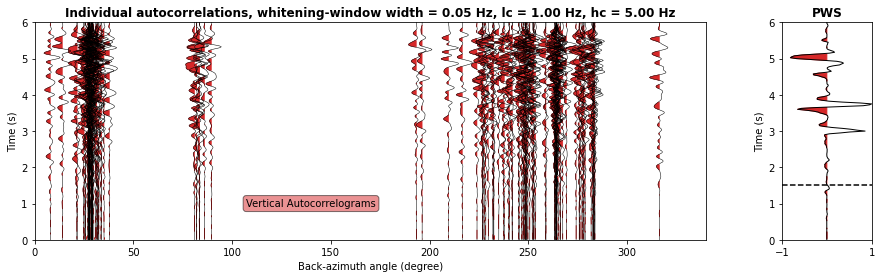

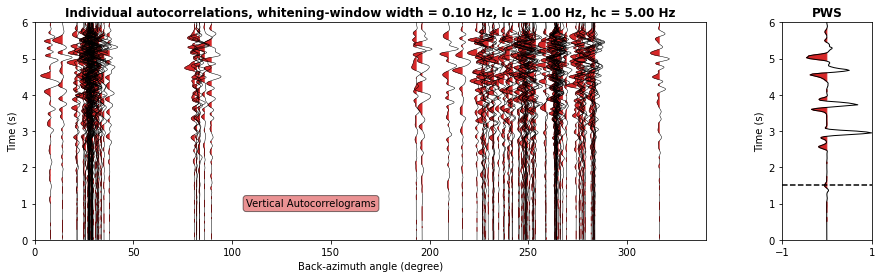

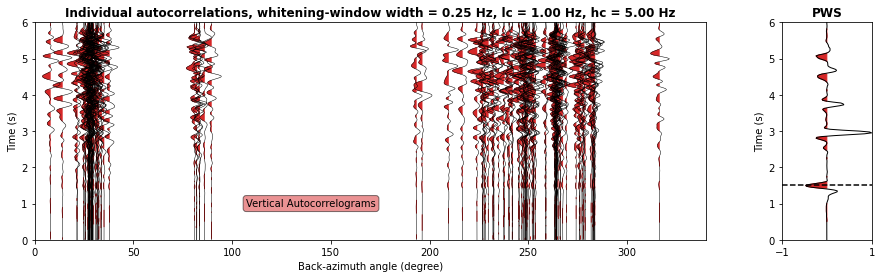

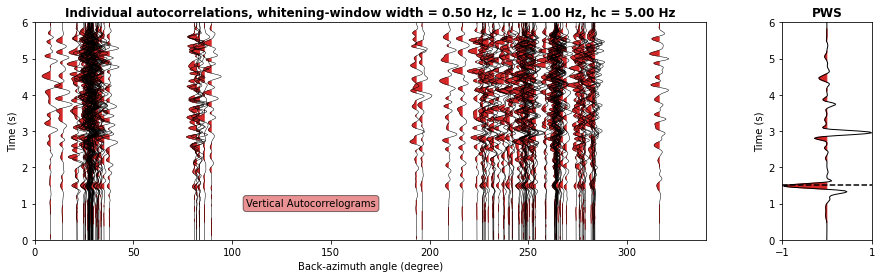

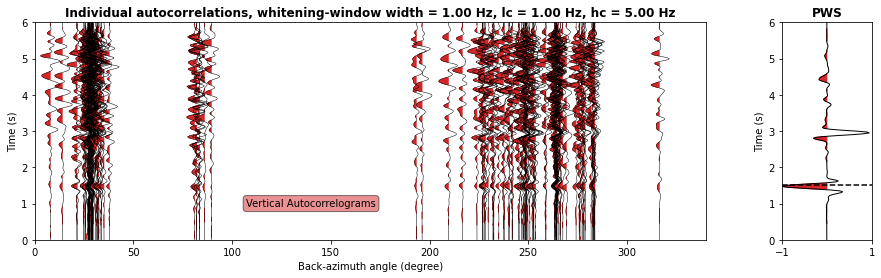

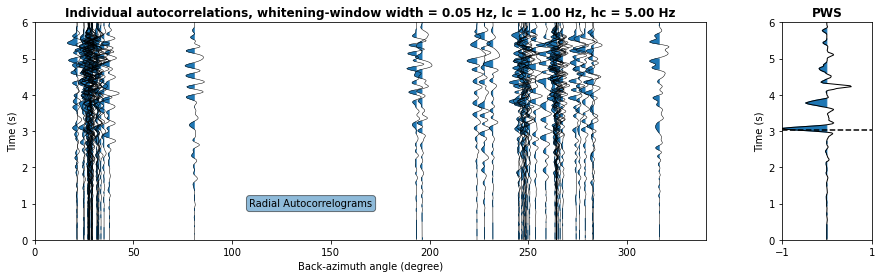

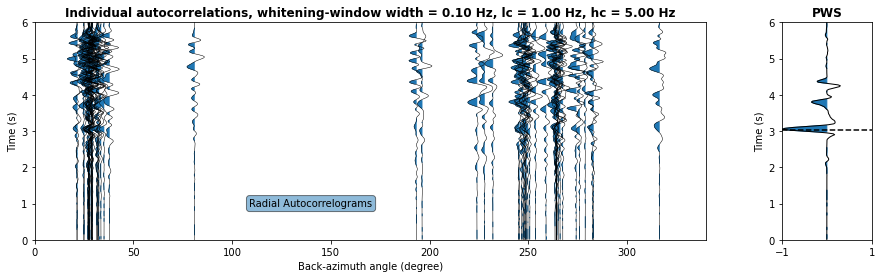

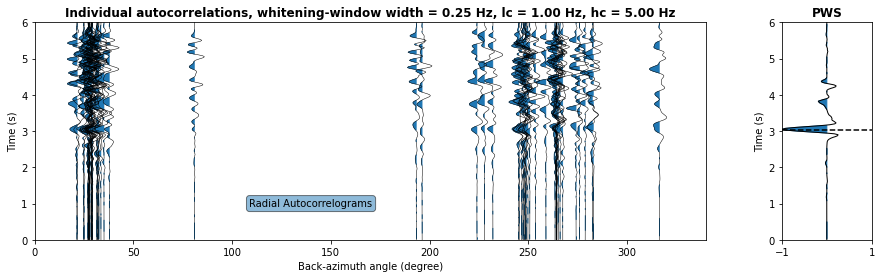

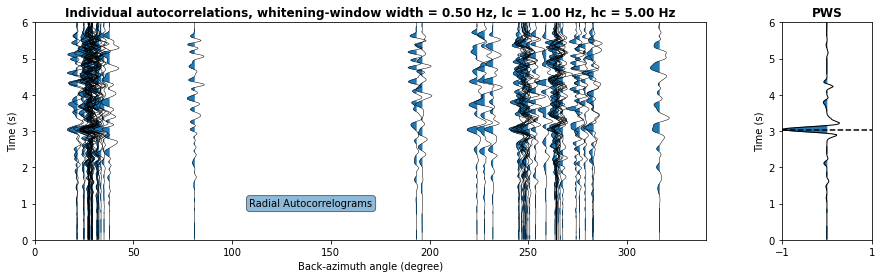

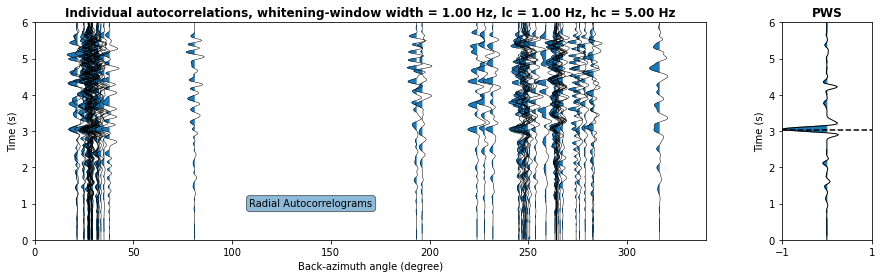

In [3]:
frequency_width = [0.05, 0.10, 0.25, 0.50, 1.00]
lc = 1.0
hc = 5.0
autolim = [0, 6]

for freq_width in frequency_width:
    process(stz, 'tab:red', 1.5, autolim)
for freq_width in frequency_width:
    process(stn, 'tab:blue', 3.02, autolim)

## **Question 3**

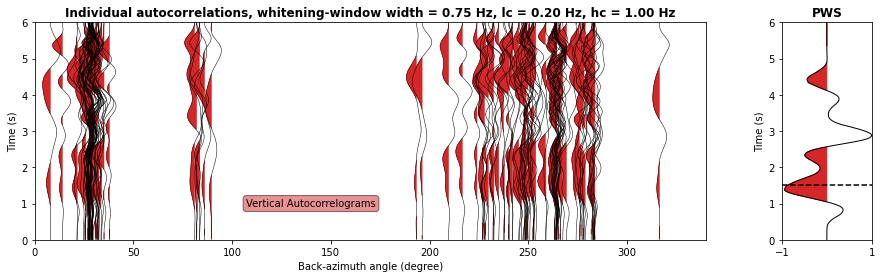

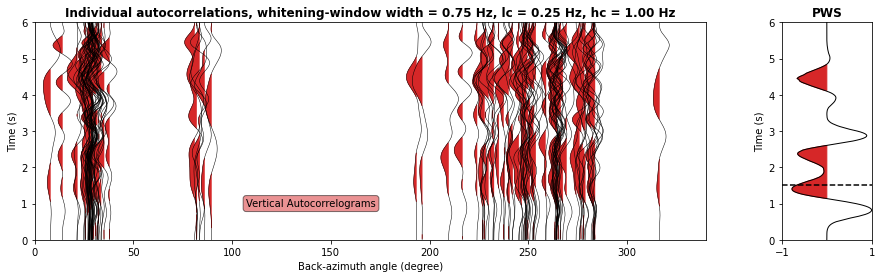

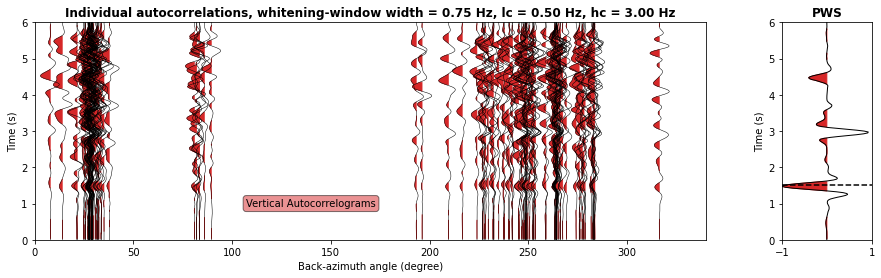

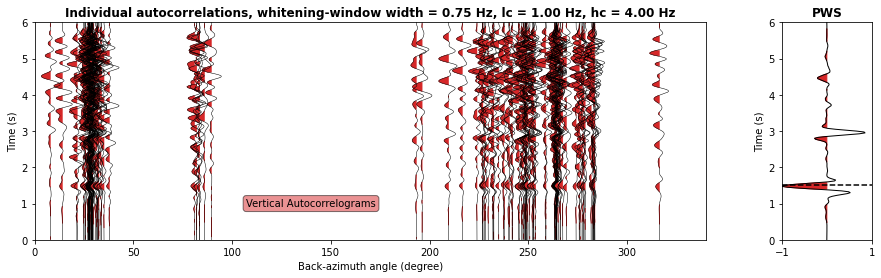

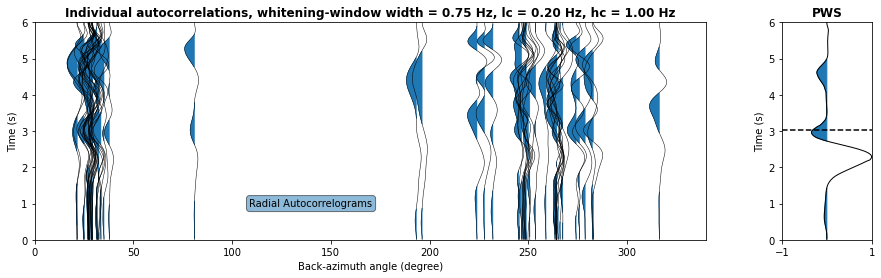

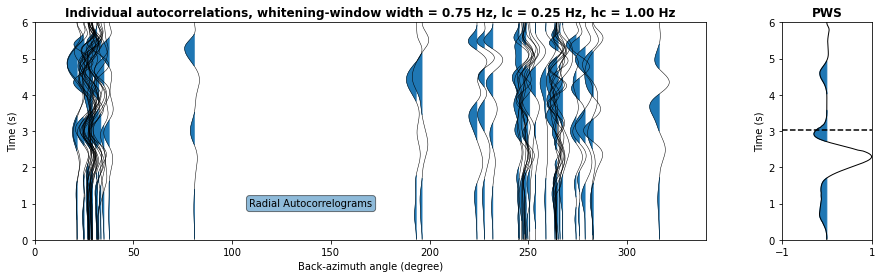

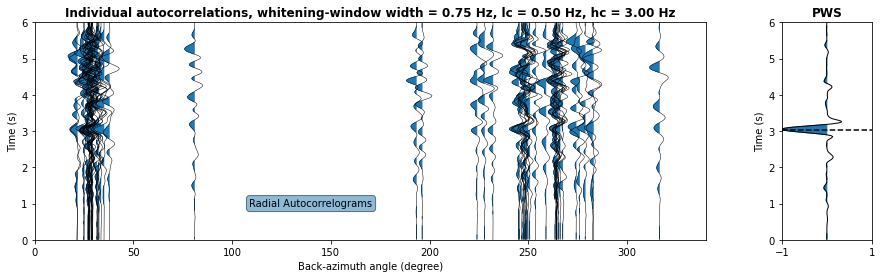

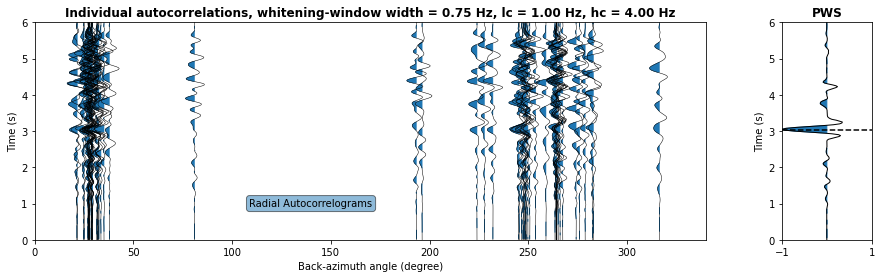

In [4]:
freq_width = 0.75
low_corner_freq = [0.20, 0.25, 0.50, 1.00]
hig_corner_freq = [1.0 , 1.0 , 3.0 , 4.00]
autolim = [0, 6]

for j in range(len(low_corner_freq)):
    lc = low_corner_freq[j]
    hc = hig_corner_freq[j]
    process(stz, 'tab:red', 1.50, autolim)
for j in range(len(low_corner_freq)):
    lc = low_corner_freq[j]
    hc = hig_corner_freq[j]
    process(stn, 'tab:blue', 3.02, autolim)

## **Question 4**

Teleseismic waves are rich in low frequencies. Therefore, the spectral-whitening function is used to normalize the bias. Consequently, we simultaneously amplify the high-frequency content and decrease the low-frequency content. The local information of the power spectrum maintained in the weighting function is controlled by the averaging window width $(2N + 1)$, which is inversely proportional to the global amplitude information preserved in the whitened spectrum. By dividing the original complex spectrum by the smoothed average trace, we were able to obtain a whitened amplitude spectrum to address the bias in the low frequency.

The spectral-whitening width affects the amplitude of the phase-weighted stacked autocorrelation at specific depth (or delayed time) because we have the relation: 
$f = 1/t_{2p(s)}$ Hz.
For example, $t_{2p} = 1.5$, the frequency $f = 1/t = 1/(1.5) = 0.66$ Hz. Therefore, in order to have the good amplification of the signal which is near delayed time of $1.5$, we need the frequency width which is near 0.66 Hz.

The $lc$ and $hc$ are the corner frequencies of the bandpass filter. When we modify the $lc$ and $hc$ from $0.20-1.0$ Hz to $1-4$ Hz, the result will change because now we just accept the frequencies in range of from $lc$ to $hc$. The bandpass filter is used to improve the sharpness of the reflection signal (by removing the very long period signals) and to avoid spurious effects caused by the unexpected amplification of very high frequency noise due to the spectral whitening.

## **Question 5**

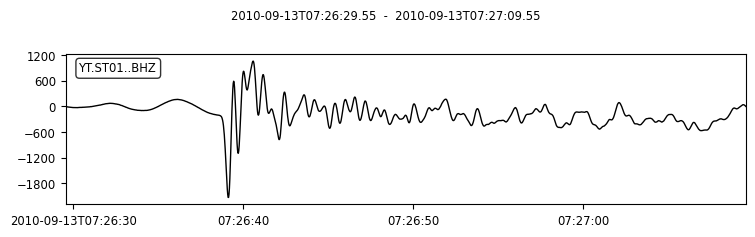

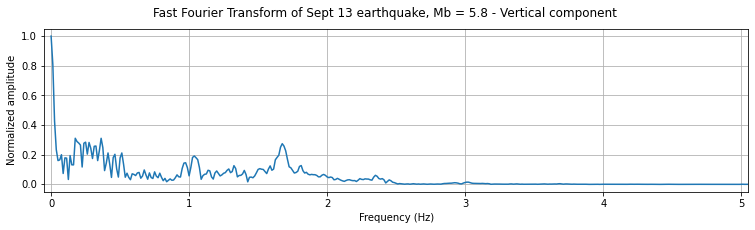

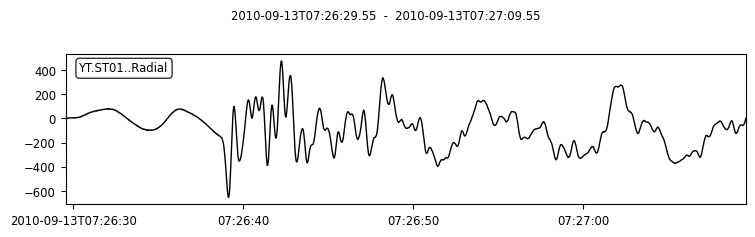

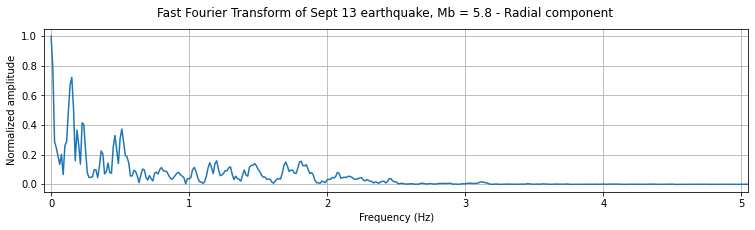

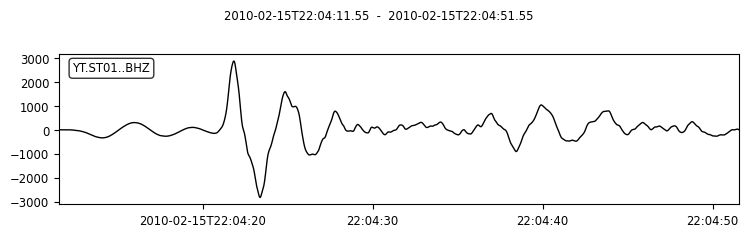

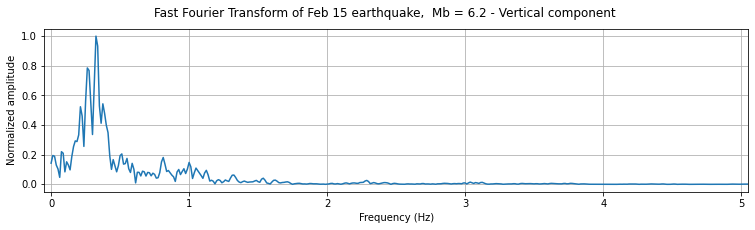

In [5]:
stz_sep13 = read("ST01/2010-09-13T7.15.50_ST01_BHZ.SAC")
stn_sep13 = read("ST01/2010-09-13T7.15.50_ST01_BHN.SAC")
stz_feb15 = read("ST01/2010-02-15T21.51.50_ST01_BHZ.SAC")
stn_sep13.traces[0].stats.starttime = stz_sep13.traces[0].stats.starttime
stn_sep13.traces[0].stats.network = stz_sep13.traces[0].stats.network
stn_sep13.traces[0].stats.station = stz_sep13.traces[0].stats.station
stn_sep13.traces[0].stats.channel = "Radial"

def fftplot(tr, title):
    dt = tr.stats.starttime
    tr.trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)
    tr.detrend("demean")
    tr.detrend("simple")
    tr.plot();
    npts = tr.stats.npts
    NF=0.5/tr.stats.delta
    npts=tr.stats.npts
    fft_tr=np.fft.fftshift(np.fft.fft(tr.data, 2*npts-1))[npts-1:2*npts]
    new_delta=NF/len(fft_tr)
    freq=np.arange(len(fft_tr))*new_delta
    plt.figure(figsize=(12.62, 3))
    plt.xlim([-0.05, 5.05])
    plt.grid()
    plt.plot(freq,np.abs(fft_tr)/max(np.abs(fft_tr)), color='tab:blue')
    plt.suptitle(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized amplitude")

fftplot(stz_sep13.traces[0], 'Fast Fourier Transform of Sept 13 earthquake, Mb = 5.8 - Vertical component')
fftplot(stn_sep13.traces[0], 'Fast Fourier Transform of Sept 13 earthquake, Mb = 5.8 - Radial component')
fftplot(stz_feb15.traces[0], 'Fast Fourier Transform of Feb 15 earthquake,  Mb = 6.2 - Vertical component')

A distant event with a source triggers the seismic wavefield, which is then modified and attenuated along its raypath before interacting with the local structure and being finally recorded in a receiver on the surface. Most of the high-frequency signals are dissipated along the journey due to attenuation in the Earth's interior. Therefore, the frequency content of the recorded waveform is biased toward the lower end of the spectrum. Therefore, to do autocorrelation, we need a step of doing the spectral whitening. For the earthquake of Mb = 6.2, the low frequencies are more dominant than low frequencies of the earthquake of Mb = 5.8. This could be the results of the distance from the event to the station. To verify, the distances of two events should be compared.

In [6]:
print("Great-circle distance from two earthquake to the station:")
print("For event on Sept 13 earthquake:", stz_sep13.traces[0].stats.sac.gcarc)
print("For event on Feb 15 earthquake:", stz_feb15.traces[0].stats.sac.gcarc)

Great-circle distance from two earthquake to the station:
For event on Sept 13 earthquake: 69.3007
For event on Feb 15 earthquake: 87.2193


As we can see, the epicentral distance from the event on Feb 15 (87.2193) is bigger than the one of the even on Sept 13 (69.3007). Therefore, low frequencies of the event on Feb 15 are dominant then the ones of the event on Sept 13.